# Загрузка файла

In [1]:
import pandas as pd
df = pd.read_csv('return_df.csv', sep = ',')

In [3]:
df

,Date,Return_BTC,Return_XRP,Return_BNB,Return_Cardano,Return_Dogecoin,Return_ETH,Return_Solana,Return_STETH,Return_USDt,Return_USDC,VYTIndex,YTIndex
0,2015-11-01,0.0465,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.790634,1
1,2015-11-02,0.1038,-0.1059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.700649,-2
2,2015-11-03,0.1104,0.1333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.601815,2
3,2015-11-04,0.0097,-0.1176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.662113,-7
4,2015-11-05,-0.0520,-0.0889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.104815,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3375,2025-01-27,-0.0036,-0.0207,0.0179,-0.0204,-0.0061,-0.0169,-0.0232,-0.025154,0.0004,-0.0003,2.259791,0
3376,2025-01-28,-0.0082,0.0016,-0.0267,-0.0191,-0.0456,-0.0320,-0.0335,-0.016904,-0.0005,0.0005,2.046806,1
3377,2025-01-29,0.0229,0.0029,0.0096,0.0259,0.0165,0.0115,0.0033,-0.035619,0.0004,-0.0006,1.899213,-2
3378,2025-01-30,0.0093,0.0194,0.0145,0.0209,0.0233,0.0430,0.0470,0.011325,0.0001,-0.0001,1.758014,-4


In [12]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.pyplot as plt
from scipy import stats
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Отключение предупреждений о проблемах сходимости
warnings.simplefilter('ignore', ConvergenceWarning)

def granger_causality_in_quantiles_troster(y, x, max_lag=1, quantiles=np.arange(0.05, 0.96, 0.05), ci_level=0.95):
    """
    Тест на причинность по Грейнджеру в квантилях (Troster, 2016, 2018).

    Параметры:
    -----------
    y : array-like
        Зависимая переменная (вызываемая)
    x : array-like
        Независимая переменная (причинитель)
    max_lag : int, default=1
        Максимальное количество лагов
    quantiles : array-like, default=np.arange(0.05, 0.96, 0.05)
        Квантили для тестирования
    ci_level : float, default=0.95
        Уровень доверия для критических значений

    Возвращает:
    --------
    results : pandas DataFrame
        DataFrame с тестовыми статистиками, p-значениями и значимостью для каждого квантиля
    """
    y = np.asarray(y)
    x = np.asarray(x)

    if len(y) != len(x):
        raise ValueError("Длина рядов y и x должна быть одинаковой")

    results = pd.DataFrame(index=quantiles,
                          columns=["Статистика Вальда", "P-значение", "Значимость"])

    # Формируем лаги
    data = pd.DataFrame({'y': y, 'x': x})
    for i in range(1, max_lag + 1):
        data[f'y_lag{i}'] = data['y'].shift(i)
        data[f'x_lag{i}'] = data['x'].shift(i)
    data = data.dropna()

    # Для каждого квантиля: квантильная регрессия и тест Вальда
    for q in quantiles:
        # Полная модель с лагами y и x
        X_full = sm.add_constant(data.filter(regex='(y_lag|x_lag)'))
        model_full = QuantReg(data['y'], X_full).fit(q=q)

        # Извлекаем коэффициенты для лагов x из полной модели
        x_lag_cols = [col for col in X_full.columns if 'x_lag' in col]
        if len(x_lag_cols) > 0:
            x_coefs = model_full.params[x_lag_cols]
            x_cov = model_full.cov_params().loc[x_lag_cols, x_lag_cols]
            # Тест Вальда для совместной значимости лагов x
            try:
                wald_stat = np.dot(np.dot(x_coefs.T, np.linalg.inv(x_cov)), x_coefs)
                p_value = 1 - stats.chi2.cdf(wald_stat, len(x_lag_cols))
            except np.linalg.LinAlgError:
                wald_stat = np.nan
                p_value = np.nan
        else:
            wald_stat = np.nan
            p_value = np.nan

        results.loc[q, "Статистика Вальда"] = wald_stat
        results.loc[q, "P-значение"] = p_value
        results.loc[q, "Значимость"] = p_value < (1 - ci_level)

    return results

def plot_quantile_causality_troster(results, title=None, save_path=None):
    """
    Визуализация результатов теста причинности по Грейнджеру в квантилях.
    """
    stat_col = 'Статистика Вальда'
    if title is None:
        title = "Параметрический тест причинности по Грейнджеру в квантилях"

    fig, ax1 = plt.subplots(figsize=(12, 6))
    color = 'tab:blue'
    ax1.set_xlabel('Квантиль', fontsize=12)
    ax1.set_ylabel(stat_col, color=color, fontsize=12)
    ax1.plot(results.index, results[stat_col], marker='o', color=color, linewidth=2)
    ax1.tick_params(axis='y', labelcolor=color)

    # Критическое значение хи-квадрат
    df = 1  # степени свободы (для одного лага)
    critical_value = stats.chi2.ppf(0.95, df)
    ax1.axhline(y=critical_value, linestyle='--', color=color, alpha=0.7,
                label=f'5% критическое значение (χ²({df})={critical_value:.2f})')
    ax1.axhline(y=0, linestyle='-', color='k', alpha=0.3)

    # Построение p-значений на вторичной оси
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('P-значение', color=color, fontsize=12)
    ax2.plot(results.index, results["P-значение"], marker='s', color=color,
             linestyle='--', linewidth=1.5)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.axhline(y=0.05, linestyle=':', color=color, alpha=0.7, label='5% уровень значимости')
    ax2.set_ylim([0, min(1, 1.1 * results["P-значение"].max())])

    # Выделение значимых квантилей
    significant = results["Значимость"]
    if significant.any():
        ax1.scatter(results.index[significant],
                    results[stat_col][significant],
                    color='green',
                    s=100,
                    zorder=3,
                    label='Значимо при 5%')

    # Легенда
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=10)

    ax1.grid(True, alpha=0.3)
    ax1.set_title(title, fontsize=14)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    return fig

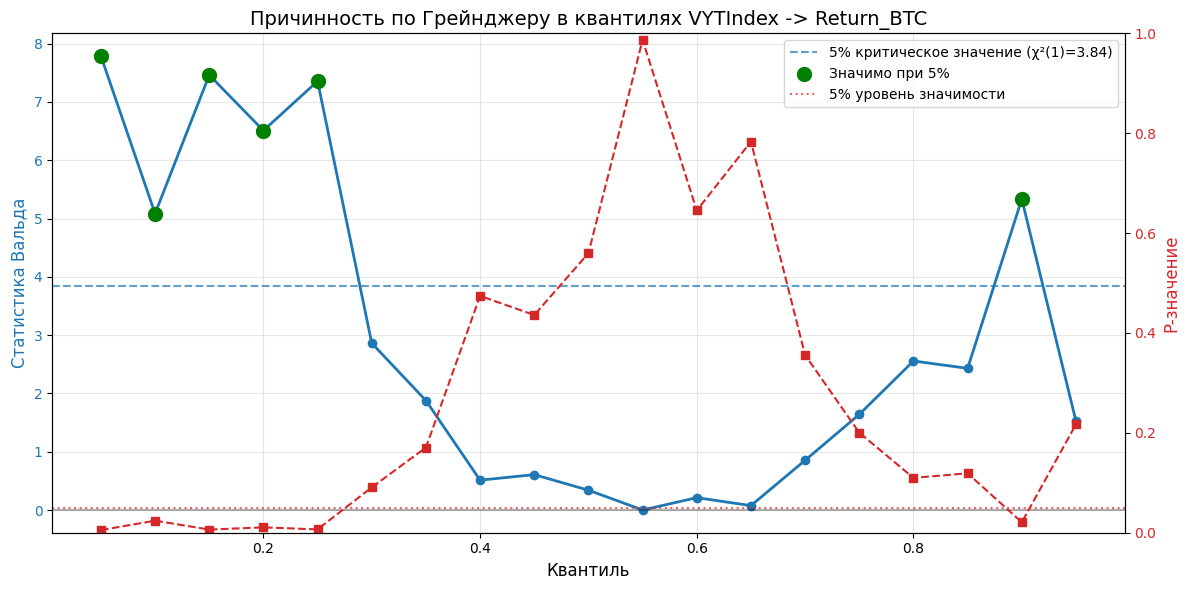

In [16]:
if __name__ == "__main__":
    results = granger_causality_in_quantiles_troster(Return_BTC, VYTIndex, max_lag=1)
    plot_quantile_causality_troster(results, title = "Причинность по Грейнджеру в квантилях VYTIndex -> Return_BTC")

In [8]:
Return_BTC = df.iloc[:,:]['Return_BTC']
VYTIndex = df.iloc[:,:]['VYTIndex']

In [7]:
df.iloc[:,:]

,Date,Return_BTC,Return_XRP,Return_BNB,Return_Cardano,Return_Dogecoin,Return_ETH,Return_Solana,Return_STETH,Return_USDt,Return_USDC,VYTIndex,YTIndex
0,2015-11-01,0.0465,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.790634,1
1,2015-11-02,0.1038,-0.1059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.700649,-2
2,2015-11-03,0.1104,0.1333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.601815,2
3,2015-11-04,0.0097,-0.1176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.662113,-7
4,2015-11-05,-0.0520,-0.0889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.104815,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3375,2025-01-27,-0.0036,-0.0207,0.0179,-0.0204,-0.0061,-0.0169,-0.0232,-0.025154,0.0004,-0.0003,2.259791,0
3376,2025-01-28,-0.0082,0.0016,-0.0267,-0.0191,-0.0456,-0.0320,-0.0335,-0.016904,-0.0005,0.0005,2.046806,1
3377,2025-01-29,0.0229,0.0029,0.0096,0.0259,0.0165,0.0115,0.0033,-0.035619,0.0004,-0.0006,1.899213,-2
3378,2025-01-30,0.0093,0.0194,0.0145,0.0209,0.0233,0.0430,0.0470,0.011325,0.0001,-0.0001,1.758014,-4


In [15]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.pyplot as plt
from scipy import stats
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Отключение предупреждений о проблемах сходимости алгоритма оптимизации
warnings.simplefilter('ignore', ConvergenceWarning)

def granger_causality_in_quantiles_troster(y, x, max_lag=1, quantiles=np.arange(0.05, 0.96, 0.05), ci_level=0.95):
    """
    # Основная функция для тестирования причинности по Грейнджеру в квантилях по методологии Troster (2018)
    # Реализует подход, описанный в разделе 2.3.1 работы
    """
    y = np.asarray(y)
    x = np.asarray(x)

    if len(y) != len(x):
        raise ValueError("Длина рядов y и x должна быть одинаковой")

    results = pd.DataFrame(index=quantiles,
                          columns=["Статистика Вальда", "P-значение", "Значимость"])

    # Формирование лагов для переменных, используемых в уравнении (2.1)
    # y_t = α(τ) + ∑β_j(τ)y_{t-j} + ∑γ_j(τ)x_{t-j} + ε_t^(τ)
    data = pd.DataFrame({'y': y, 'x': x})
    for i in range(1, max_lag + 1):
        data[f'y_lag{i}'] = data['y'].shift(i)
        data[f'x_lag{i}'] = data['x'].shift(i)
    data = data.dropna()

    # Для каждого квантиля τ выполняем оценку квантильной регрессии и тест Вальда
    for q in quantiles:
        # Оценка полной модели квантильной регрессии согласно уравнению (2.1)
        X_full = sm.add_constant(data.filter(regex='(y_lag|x_lag)'))
        model_full = QuantReg(data['y'], X_full).fit(q=q)

        # Извлечение коэффициентов γ_j(τ) для лагов x и их ковариационной матрицы
        x_lag_cols = [col for col in X_full.columns if 'x_lag' in col]
        if len(x_lag_cols) > 0:
            # Вектор оценок γ̂(τ) для лагов переменной x
            x_coefs = model_full.params[x_lag_cols]
            # Ковариационная матрица Σ̂(τ) для оценок лагов x
            x_cov = model_full.cov_params().loc[x_lag_cols, x_lag_cols]

            # Расчет статистики Вальда по формуле (2.3):
            # W(τ) = γ̂(τ)' [Σ̂(τ)]^(-1) γ̂(τ)
            try:
                wald_stat = np.dot(np.dot(x_coefs.T, np.linalg.inv(x_cov)), x_coefs)
                # Расчет p-значения по формуле (2.4) с использованием хи-квадрат распределения
                # p-value = 1 - F_χ²(W(τ))
                p_value = 1 - stats.chi2.cdf(wald_stat, len(x_lag_cols))
            except np.linalg.LinAlgError:
                wald_stat = np.nan
                p_value = np.nan
        else:
            wald_stat = np.nan
            p_value = np.nan

        # Сохранение результатов для проверки гипотез из уравнения (2.2)
        # H₀: γ₁(τ) = γ₂(τ) = ... = γₚ(τ) = 0
        results.loc[q, "Статистика Вальда"] = wald_stat
        results.loc[q, "P-значение"] = p_value
        results.loc[q, "Значимость"] = p_value < (1 - ci_level)

    return results

def plot_quantile_causality_troster(results, title=None, save_path=None):
    """
    # Функция для визуализации результатов теста причинности по Грейнджеру в квантилях
    # Создает график со статистикой Вальда и p-значениями для каждого квантиля
    """
    stat_col = 'Статистика Вальда'
    if title is None:
        title = "Параметрический тест причинности по Грейнджеру в квантилях (Troster, 2016, 2018)"

    fig, ax1 = plt.subplots(figsize=(12, 6))
    color = 'tab:blue'
    ax1.set_xlabel('Квантиль', fontsize=12)
    ax1.set_ylabel(stat_col, color=color, fontsize=12)
    ax1.plot(results.index, results[stat_col], marker='o', color=color, linewidth=2)
    ax1.tick_params(axis='y', labelcolor=color)

    # Горизонтальная линия критического значения χ² для проверки гипотезы (2.2)
    df = 1  # степени свободы (для одного лага)
    critical_value = stats.chi2.ppf(0.95, df)
    ax1.axhline(y=critical_value, linestyle='--', color=color, alpha=0.7,
                label=f'5% критическое значение (χ²({df})={critical_value:.2f})')
    ax1.axhline(y=0, linestyle='-', color='k', alpha=0.3)

    # Построение графика p-значений на вторичной оси
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('P-значение', color=color, fontsize=12)
    ax2.plot(results.index, results["P-значение"], marker='s', color=color,
             linestyle='--', linewidth=1.5)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.axhline(y=0.05, linestyle=':', color=color, alpha=0.7, label='5% уровень значимости')
    ax2.set_ylim([0, min(1, 1.1 * results["P-значение"].max())])

    # Выделение квантилей, на которых отвергается нулевая гипотеза (2.2)
    significant = results["Значимость"]
    if significant.any():
        ax1.scatter(results.index[significant],
                    results[stat_col][significant],
                    color='green',
                    s=100,
                    zorder=3,
                    label='Значимо при 5%')

    # Добавление легенды
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=10)

    ax1.grid(True, alpha=0.3)
    ax1.set_title(title, fontsize=14)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    return fig

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.pyplot as plt
from scipy.stats import chi2

def granger_causality_in_quantiles(y, x, max_lag=1, quantiles=np.arange(0.05, 0.96, 0.05)):
    """
    Тест причинности по Грейнджеру в квантилях (Troster, 2016, 2018)

    Параметры:
    y: pd.Series - зависимая переменная
    x: pd.Series - независимая переменная
    max_lag: int - количество лагов
    quantiles: array - исследуемые квантили

    Возвращает:
    results: dict - квантили, p-values и статистики теста
    """

    # Создаем лагированные переменные
    df = pd.DataFrame({'y': y, 'x': x})
    for i in range(1, max_lag + 1):
        df[f'y_lag{i}'] = df['y'].shift(i)
        df[f'x_lag{i}'] = df['x'].shift(i)

    df = df.dropna()
    X = sm.add_constant(df.filter(regex='(y_lag|x_lag)'))
    y_curr = df['y']

    # Результаты теста
    p_values = []
    wald_stats = []

    # Индексы лагов x
    x_lag_columns = [col for col in X.columns if 'x_lag' in col]
    x_indices = [X.columns.get_loc(col) for col in x_lag_columns]

    for tau in quantiles:
        # Оцениваем квантильную регрессию
        model = QuantReg(y_curr, X).fit(q=tau)

        # Тест Вальда для лагов x
        R = np.eye(len(X.columns))[x_indices]
        try:
            wald_stat = model.wald_test(R, scalar=True).statistic[0][0]
            p_val = model.wald_test(R, scalar=True).pvalue
        except:
            wald_stat = np.nan
            p_val = np.nan

        p_values.append(p_val)
        wald_stats.append(wald_stat)

    return {
        'quantiles': quantiles,
        'p_values': p_values,
        'wald_stats': wald_stats
    }

def plot_granger_results(results, title=None):
    """Визуализация результатов теста"""
    plt.figure(figsize=(10,6))
    plt.plot(results['quantiles'], results['p_values'], 'bo-')
    plt.axhline(0.05, color='red', linestyle='--')
    plt.title(title or "Granger Causality in Quantiles Test (Troster, 2016, 2018)")
    plt.xlabel('Quantiles')
    plt.ylabel('p-value')
    plt.grid(True)
    plt.show()

# Пример использования
if __name__ == "__main__":
    # Генерация тестовых данных
    np.random.seed(42)
    n = 1000
    y = np.random.normal(0, 1, n).cumsum() + np.random.normal(0, 0.5, n)
    x = np.random.normal(0, 1, n).cumsum() + np.random.normal(0, 0.5, n)

    # Запуск теста
    results = granger_causality_in_quantiles(pd.Series(y), pd.Series(x), max_lag=2)

    # Визуализация
    plot_granger_results(results, "Пример теста Troster для синтетических данных")


In [134]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.pyplot as plt
from scipy import stats
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Отключение предупреждений о проблемах сходимости
warnings.simplefilter('ignore', ConvergenceWarning)

def granger_causality_in_quantiles(y, x, max_lag=1, quantiles=np.arange(0.05, 0.96, 0.05),
                                  method='parametric', bandwidth=None, ci_level=0.95):
    """
    Тест на причинность по Грейнджеру в квантилях.

    Параметры:
    -----------
    y : array-like
        Зависимая переменная (потенциально "вызываемая")
    x : array-like
        Независимая переменная (потенциальный "причинитель")
    max_lag : int, default=1
        Максимальное количество лагов для теста
    quantiles : array-like, default=np.arange(0.05, 0.96, 0.05)
        Квантили для тестирования причинности
    method : str, default='parametric'
        Метод для тестирования причинности. Варианты: 'parametric' (Troster, 2018) или
        'nonparametric' (Jeong et al., 2012)
    bandwidth : float, optional
        Ширина окна для сглаживания ядра в непараметрическом методе.
        Если None, используется правило большого пальца Сильвермана.
    ci_level : float, default=0.95
        Уровень доверия для критических значений

    Возвращает:
    --------
    results : pandas DataFrame
        DataFrame, содержащий тестовые статистики, p-значения и значимость для каждого квантиля
    """
    y = np.asarray(y)
    x = np.asarray(x)

    # Убеждаемся, что ряды имеют одинаковую длину
    if len(y) != len(x):
        raise ValueError("Длина рядов y и x должна быть одинаковой")

    # Сохраняем результаты
    if method == 'parametric':
        results = pd.DataFrame(index=quantiles,
                              columns=["Статистика Вальда", "P-значение", "Значимость"])
    else:
        results = pd.DataFrame(index=quantiles,
                              columns=["Тестовая статистика", "P-значение", "Значимость"])

    # Создаем данные с лагами
    data = pd.DataFrame({'y': y, 'x': x})
    for i in range(1, max_lag + 1):
        data[f'y_lag{i}'] = data['y'].shift(i)
        data[f'x_lag{i}'] = data['x'].shift(i)

    # Удаляем строки с NaN из-за лагирования
    data = data.dropna()

    # Для каждого квантиля
    for q in quantiles:
        if method == 'parametric':
            # Параметрический подход (Troster, 2018)

            # Полная модель с лагами y и x
            X_full = sm.add_constant(data.filter(regex='(y_lag|x_lag)'))
            model_full = QuantReg(data['y'], X_full).fit(q=q)

            # Ограниченная модель только с лагами y
            X_restr = sm.add_constant(data.filter(like='y_lag'))
            model_restr = QuantReg(data['y'], X_restr).fit(q=q)

            # Извлекаем коэффициенты для лагов x из полной модели
            x_lag_cols = [col for col in X_full.columns if 'x_lag' in col]
            if len(x_lag_cols) > 0:
                x_coefs = model_full.params[x_lag_cols]
                x_cov = model_full.cov_params().loc[x_lag_cols, x_lag_cols]

                # Тест Вальда для совместной значимости лагов x
                try:
                    wald_stat = np.dot(np.dot(x_coefs.T, np.linalg.inv(x_cov)), x_coefs)
                    p_value = 1 - stats.chi2.cdf(wald_stat, len(x_lag_cols))
                except np.linalg.LinAlgError:
                    # Обработка сингулярной матрицы
                    wald_stat = np.nan
                    p_value = np.nan
            else:
                wald_stat = np.nan
                p_value = np.nan

            results.loc[q, "Статистика Вальда"] = wald_stat
            results.loc[q, "P-значение"] = p_value
            results.loc[q, "Значимость"] = p_value < (1 - ci_level)

        else:
            # Непараметрический подход (Jeong et al., 2012)

            # Модель 1: Только с лагами y
            X1 = sm.add_constant(data.filter(like='y_lag'))
            model1 = QuantReg(data['y'], X1).fit(q=q)
            quantile_pred1 = model1.predict(X1)

            # Модель 2: С лагами и y, и x
            X2 = sm.add_constant(data.filter(regex='(y_lag|x_lag)'))
            model2 = QuantReg(data['y'], X2).fit(q=q)
            quantile_pred2 = model2.predict(X2)

            # Рассчитываем значения функции проверки
            def check_function(u, tau):
                return u * (tau - (u < 0))

            resid1 = data['y'] - quantile_pred1
            resid2 = data['y'] - quantile_pred2

            diff = check_function(resid1, q) - check_function(resid2, q)

            # Правило большого пальца Сильвермана для ширины окна, если не предоставлено
            if bandwidth is None:
                bandwidth = 1.06 * np.std(diff) * len(diff) ** (-1/5)

            # Ядерная оценка для тестовой статистики
            n = len(diff)
            test_stat = np.sqrt(n * bandwidth) * np.mean(diff) / np.std(diff)
            p_value = 2 * (1 - stats.norm.cdf(abs(test_stat)))  # Двусторонний тест

            results.loc[q, "Тестовая статистика"] = test_stat
            results.loc[q, "P-значение"] = p_value
            results.loc[q, "Значимость"] = p_value < (1 - ci_level)

    return results

def plot_quantile_causality(results, title=None, save_path=None):
    """
    Построение графика результатов теста причинности по Грейнджеру в квантилях.

    Параметры:
    -----------
    results : pandas DataFrame
        DataFrame, содержащий тестовые статистики и p-значения для каждого квантиля
    title : str, optional
        Заголовок для графика. Если None, будет создан заголовок по умолчанию.
    save_path : str, optional
        Путь для сохранения графика. Если None, график не сохраняется.

    Возвращает:
    --------
    fig : matplotlib.figure.Figure
        Объект фигуры
    """
    if 'Статистика Вальда' in results.columns:
        method = 'parametric'
        stat_col = 'Статистика Вальда'
        if title is None:
            title = "Параметрический тест причинности по Грейнджеру в квантилях (Troster, 2018)"
    else:
        method = 'nonparametric'
        stat_col = 'Тестовая статистика'
        if title is None:
            title = "Непараметрический тест причинности по Грейнджеру в квантилях (Jeong et al., 2012)"

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Построение тестовых статистик
    color = 'tab:blue'
    ax1.set_xlabel('Квантиль', fontsize=12)
    ax1.set_ylabel(stat_col, color=color, fontsize=12)
    ax1.plot(results.index, results[stat_col], marker='o', color=color, linewidth=2)
    ax1.tick_params(axis='y', labelcolor=color)

    # Добавление линии критического значения
    if method == 'parametric':
        # Для параметрического метода используем критическое значение хи-квадрат
        df = 1  # степени свободы (для одного лага)
        critical_value = stats.chi2.ppf(0.95, df)
        ax1.axhline(y=critical_value, linestyle='--', color=color, alpha=0.7,
                    label=f'5% критическое значение (χ²({df})={critical_value:.2f})')
    else:
        # Для непараметрического метода используем нормальные критические значения
        critical_value = stats.norm.ppf(0.975)  # 97.5-й процентиль для двустороннего теста при 5%
        ax1.axhline(y=critical_value, linestyle='--', color=color, alpha=0.7,
                    label=f'5% критическое значение (z={critical_value:.2f})')
        ax1.axhline(y=-critical_value, linestyle='--', color=color, alpha=0.7)

    ax1.axhline(y=0, linestyle='-', color='k', alpha=0.3)

    # Построение p-значений на вторичной оси
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('P-значение', color=color, fontsize=12)
    ax2.plot(results.index, results["P-значение"], marker='s', color=color,
             linestyle='--', linewidth=1.5)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.axhline(y=0.05, linestyle=':', color=color, alpha=0.7, label='5% уровень значимости')
    ax2.set_ylim([0, min(1, 1.1 * results["P-значение"].max())])

    # Выделение значимых квантилей
    significant = results["Значимость"]
    if significant.any():
        ax1.scatter(results.index[significant],
                    results[stat_col][significant],
                    color='green',
                    s=100,
                    zorder=3,
                    label='Значимо при 5%')

    # Добавление легенды
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=10)

    ax1.grid(True, alpha=0.3)
    ax1.set_title(title, fontsize=14)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig

In [ ]:
# Загрузка данных
import pandas as pd
import numpy as np

# Предположим, что у нас есть данные индекса неопределенности и доходности биткоина
uncertainty_index = df['Return_BTC']
btc_returns = df['YTIndex']

# # Для демонстрации создадим синтетический пример
# np.random.seed(123)
# n = 500

# # Создаем индекс неопределенности с авторегрессионной структурой
# uncertainty_index = np.zeros(n)
# for t in range(1, n):
#     uncertainty_index[t] = 0.7 * uncertainty_index[t-1] + np.random.normal(0, 1)

# # Создаем доходность биткоина с зависимостью от индекса неопределенности в разных квантилях
# e = np.random.normal(0, 1, n)
# btc_returns = np.zeros(n)
# for t in range(1, n):
#     if e[t] < -0.8:  # Сильное влияние в нижних квантилях (медвежий рынок)
#         btc_returns[t] = 0.2 * btc_returns[t-1] + 0.5 * uncertainty_index[t-1] + e[t]
#     elif e[t] > 0.8:  # Сильное влияние в верхних квантилях (бычий рынок)
#         btc_returns[t] = 0.2 * btc_returns[t-1] - 0.3 * uncertainty_index[t-1] + e[t]
#     else:  # Слабое влияние в средних квантилях
#         btc_returns[t] = 0.2 * btc_returns[t-1] + 0.1 * uncertainty_index[t-1] + e[t]

# Тестирование причинности
quantiles = np.arange(0.05, 0.96, 0.05)
results = granger_causality_in_quantiles(Return_STETH, VYTIndex,
                                         max_lag=1,
                                         quantiles=quantiles,
                                         method='parametric')
# VYTIndex, Return_BTC,
# # Визуализация результатов
plot_quantile_causality(results,
                        title="Причинность по Грейнджеру в квантилях: Индекс неопределенности → Доходность BTC")

# # Проверка обратной причинности
# results_reverse = granger_causality_in_quantiles(uncertainty_index, btc_returns,
#                                                 max_lag=1,
#                                                 quantiles=quantiles,
#                                                 method='parametric')

# plot_quantile_causality(results_reverse,
#                         title="Причинность по Грейнджеру в квантилях: Доходность BTC → Индекс неопределенности")


In [128]:
Return_STETH = df.iloc[2200:3684,:12]['Return_STETH']
VYTIndex = df.iloc[2200:3684,:12]['VYTIndex']

In [125]:
df.iloc[2200:3684,:12]

,Date,Return_BTC,Return_XRP,Return_BNB,Return_Cardano,Return_Dogecoin,Return_ETH,Return_Solana,Return_STETH,Return_USDt,Return_USDC,VYTIndex
2200,2021-01-09,-0.0083,0.0110,0.0355,0.0862,0.0415,0.0492,-0.2285,0.040472,0.0031,-0.0028,2.544444
2201,2021-01-10,-0.0484,-0.0281,-0.0319,-0.0843,-0.0322,-0.0153,0.0176,0.018391,-0.0023,0.0033,2.326174
2202,2021-01-11,-0.0719,-0.0878,-0.0984,-0.0874,-0.1020,-0.1310,0.0177,0.011664,0.0000,-0.0001,2.113359
2203,2021-01-12,-0.0387,0.0171,0.0000,0.0424,-0.0863,-0.0378,0.1688,-0.147124,0.0006,0.0009,1.921572
2204,2021-01-13,0.0959,0.0454,0.0489,0.0874,0.0747,0.0745,-0.0314,-0.034646,-0.0012,-0.0008,2.200861
...,...,...,...,...,...,...,...,...,...,...,...,...
3679,2025-01-27,-0.0036,-0.0207,0.0179,-0.0204,-0.0061,-0.0169,-0.0232,-0.025154,0.0004,-0.0003,2.259791
3680,2025-01-28,-0.0082,0.0016,-0.0267,-0.0191,-0.0456,-0.0320,-0.0335,-0.016904,-0.0005,0.0005,2.046806
3681,2025-01-29,0.0229,0.0029,0.0096,0.0259,0.0165,0.0115,0.0033,-0.035619,0.0004,-0.0006,1.899213
3682,2025-01-30,0.0093,0.0194,0.0145,0.0209,0.0233,0.0430,0.0470,0.011325,0.0001,-0.0001,1.758014


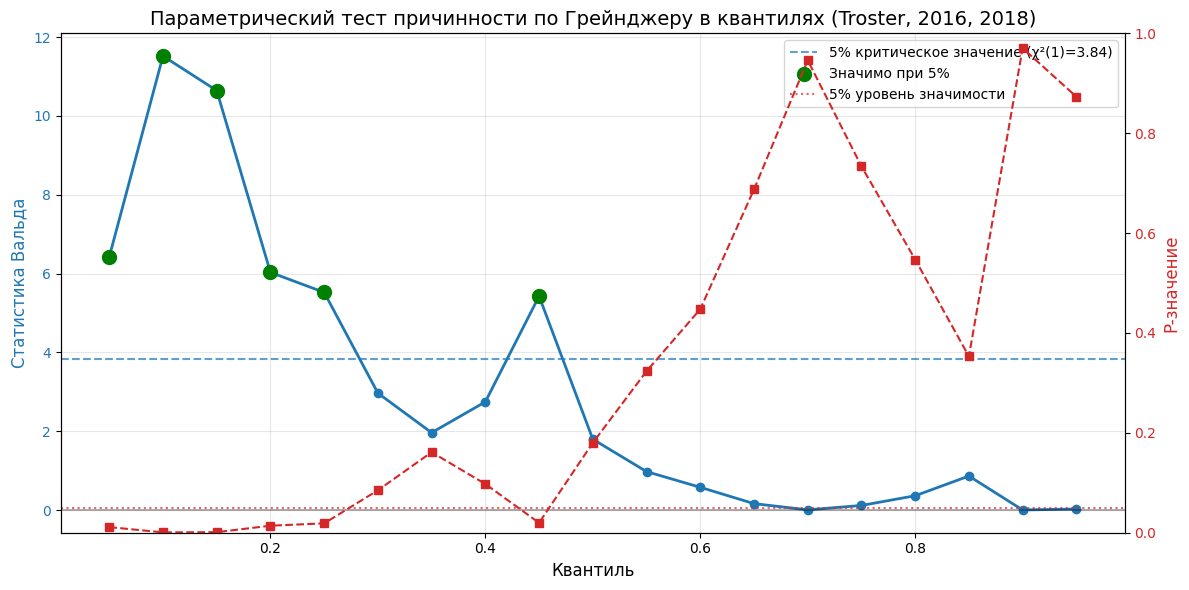

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.pyplot as plt
from scipy import stats
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Отключение предупреждений о проблемах сходимости
warnings.simplefilter('ignore', ConvergenceWarning)

def granger_causality_in_quantiles_troster(y, x, max_lag=1, quantiles=np.arange(0.05, 0.96, 0.05), ci_level=0.95):
    """
    Тест на причинность по Грейнджеру в квантилях (Troster, 2016, 2018).

    Параметры:
    -----------
    y : array-like
        Зависимая переменная (вызываемая)
    x : array-like
        Независимая переменная (причинитель)
    max_lag : int, default=1
        Максимальное количество лагов
    quantiles : array-like, default=np.arange(0.05, 0.96, 0.05)
        Квантили для тестирования
    ci_level : float, default=0.95
        Уровень доверия для критических значений

    Возвращает:
    --------
    results : pandas DataFrame
        DataFrame с тестовыми статистиками, p-значениями и значимостью для каждого квантиля
    """
    y = np.asarray(y)
    x = np.asarray(x)

    if len(y) != len(x):
        raise ValueError("Длина рядов y и x должна быть одинаковой")

    results = pd.DataFrame(index=quantiles,
                          columns=["Статистика Вальда", "P-значение", "Значимость"])

    # Формируем лаги
    data = pd.DataFrame({'y': y, 'x': x})
    for i in range(1, max_lag + 1):
        data[f'y_lag{i}'] = data['y'].shift(i)
        data[f'x_lag{i}'] = data['x'].shift(i)
    data = data.dropna()

    # Для каждого квантиля: квантильная регрессия и тест Вальда
    for q in quantiles:
        # Полная модель с лагами y и x
        X_full = sm.add_constant(data.filter(regex='(y_lag|x_lag)'))
        model_full = QuantReg(data['y'], X_full).fit(q=q)

        # Извлекаем коэффициенты для лагов x из полной модели
        x_lag_cols = [col for col in X_full.columns if 'x_lag' in col]
        if len(x_lag_cols) > 0:
            x_coefs = model_full.params[x_lag_cols]
            x_cov = model_full.cov_params().loc[x_lag_cols, x_lag_cols]
            # Тест Вальда для совместной значимости лагов x
            try:
                wald_stat = np.dot(np.dot(x_coefs.T, np.linalg.inv(x_cov)), x_coefs)
                p_value = 1 - stats.chi2.cdf(wald_stat, len(x_lag_cols))
            except np.linalg.LinAlgError:
                wald_stat = np.nan
                p_value = np.nan
        else:
            wald_stat = np.nan
            p_value = np.nan

        results.loc[q, "Статистика Вальда"] = wald_stat
        results.loc[q, "P-значение"] = p_value
        results.loc[q, "Значимость"] = p_value < (1 - ci_level)

    return results

def plot_quantile_causality_troster(results, title=None, save_path=None):
    """
    Визуализация результатов теста причинности по Грейнджеру в квантилях (Troster).
    """
    stat_col = 'Статистика Вальда'
    if title is None:
        title = "Параметрический тест причинности по Грейнджеру в квантилях (Troster, 2016, 2018)"

    fig, ax1 = plt.subplots(figsize=(12, 6))
    color = 'tab:blue'
    ax1.set_xlabel('Квантиль', fontsize=12)
    ax1.set_ylabel(stat_col, color=color, fontsize=12)
    ax1.plot(results.index, results[stat_col], marker='o', color=color, linewidth=2)
    ax1.tick_params(axis='y', labelcolor=color)

    # Критическое значение хи-квадрат
    df = 1  # степени свободы (для одного лага)
    critical_value = stats.chi2.ppf(0.95, df)
    ax1.axhline(y=critical_value, linestyle='--', color=color, alpha=0.7,
                label=f'5% критическое значение (χ²({df})={critical_value:.2f})')
    ax1.axhline(y=0, linestyle='-', color='k', alpha=0.3)

    # Построение p-значений на вторичной оси
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('P-значение', color=color, fontsize=12)
    ax2.plot(results.index, results["P-значение"], marker='s', color=color,
             linestyle='--', linewidth=1.5)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.axhline(y=0.05, linestyle=':', color=color, alpha=0.7, label='5% уровень значимости')
    ax2.set_ylim([0, min(1, 1.1 * results["P-значение"].max())])

    # Выделение значимых квантилей
    significant = results["Значимость"]
    if significant.any():
        ax1.scatter(results.index[significant],
                    results[stat_col][significant],
                    color='green',
                    s=100,
                    zorder=3,
                    label='Значимо при 5%')

    # Легенда
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=10)

    ax1.grid(True, alpha=0.3)
    ax1.set_title(title, fontsize=14)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    return fig

# Пример использования:
if __name__ == "__main__":
    np.random.seed(42)
    results = granger_causality_in_quantiles_troster(Return_STETH, VYTIndex, max_lag=1)
    plot_quantile_causality_troster(results)

In [5]:
df.iloc[2200:3684,:12]

,Date,Return_BTC,Return_XRP,Return_BNB,Return_Cardano,Return_Dogecoin,Return_ETH,Return_Solana,Return_STETH,Return_USDt,Return_USDC,VYTIndex
2200,2021-01-09,-0.0083,0.0110,0.0355,0.0862,0.0415,0.0492,-0.2285,0.040472,0.0031,-0.0028,2.544444
2201,2021-01-10,-0.0484,-0.0281,-0.0319,-0.0843,-0.0322,-0.0153,0.0176,0.018391,-0.0023,0.0033,2.326174
2202,2021-01-11,-0.0719,-0.0878,-0.0984,-0.0874,-0.1020,-0.1310,0.0177,0.011664,0.0000,-0.0001,2.113359
2203,2021-01-12,-0.0387,0.0171,0.0000,0.0424,-0.0863,-0.0378,0.1688,-0.147124,0.0006,0.0009,1.921572
2204,2021-01-13,0.0959,0.0454,0.0489,0.0874,0.0747,0.0745,-0.0314,-0.034646,-0.0012,-0.0008,2.200861
...,...,...,...,...,...,...,...,...,...,...,...,...
3679,2025-01-27,-0.0036,-0.0207,0.0179,-0.0204,-0.0061,-0.0169,-0.0232,-0.025154,0.0004,-0.0003,2.259791
3680,2025-01-28,-0.0082,0.0016,-0.0267,-0.0191,-0.0456,-0.0320,-0.0335,-0.016904,-0.0005,0.0005,2.046806
3681,2025-01-29,0.0229,0.0029,0.0096,0.0259,0.0165,0.0115,0.0033,-0.035619,0.0004,-0.0006,1.899213
3682,2025-01-30,0.0093,0.0194,0.0145,0.0209,0.0233,0.0430,0.0470,0.011325,0.0001,-0.0001,1.758014


In [4]:
Return_STETH = df.iloc[2200:3684,:12]['Return_STETH']
VYTIndex = df.iloc[2200:3684,:12]['VYTIndex']